In [ ]:
# AQUI PASSAMOS OS VALORES COMO PARÂMETRO, LEVANDO EM CONSIDERAÇÃO OS TIPOS DE CÂMERAS (CONFORME ARTIGO)
cameras = {
    "GC0308":  {"noise": 2.38, "sharpness": 103.36, "contrast": 81.50},
    "NT99141": {"noise": 11.10, "sharpness": 228.30, "contrast": 61.75},
    "OV2640":  {"noise": 13.66, "sharpness": 163.00, "contrast": 83.01},
    "OV7670":  {"noise": 18.76, "sharpness": 409.87, "contrast": 94.39},
    "OV7725":  {"noise": 6.63, "sharpness": 214.29, "contrast": 82.86}
}

UTILIZANDO  A BIBLIOTECA PILLOW



In [ ]:
from PIL import Image, ImageEnhance, ImageFilter
import numpy as np
import matplotlib.pyplot as plt


In [ ]:
def aplicar_configuracoes_pillow(imagem, noise, sharpness, contrast):
    # Garante que está no modo RGB
    # QUE BASICAMENTE É UM MODO DE COR, QUE APRIMORA O CONTRASTE E A NITIDEZ
    img = imagem.convert("RGB")

    # --- Ajustar nitidez ---
    # SE RETORNAR 1.0 RETORNA A IMAGEM ORIGINAL
    # SE RETORNAR ABAIXO QUE 1.0 ELE BORRA A IMAGEM
    # E ACIMA DE 1.0 TORNA ELA MAIS NÍTIDA

    enhancer_sharp = ImageEnhance.Sharpness(img)
    img = enhancer_sharp.enhance(sharpness / 100)

    # --- Ajustar contraste ---
    # COMO PASSAMOS O VALOR 80, SE RETORNA 40 ELE COLOCA A METADE DO CONTRASTE
    # SE RETORNAR 160 ELE ADICIONA O DOBRO DE CONTRASTE.

    enhancer_contrast = ImageEnhance.Contrast(img)
    img = enhancer_contrast.enhance(contrast / 80)

    # --- Adicionar ruído---
    # TRANSFORMA A IMAGEM EM UM ARRAY NUMPY
    np_img = np.array(img, dtype=np.float32)
    noise_array = np.random.normal(0, noise, np_img.shape)
    # AQUI ELE ESTA SOMANDO OS VALORES DE RUIDO COM OS PIXELS DA IMAGEM
    # O NP.CLIP GARANTE QUE A IMAGEM NÃO SAIA DA ESCALA DE 0 A 255,E POR FIM RETORNA PARA UMA IMAGEM DE 8 BITS.
    np_img = np.clip(np_img + noise_array, 0, 255).astype(np.uint8)
    img = Image.fromarray(np_img)

    return img


In [ ]:
# Abrir imagem
img = Image.open("/content/10011.png")

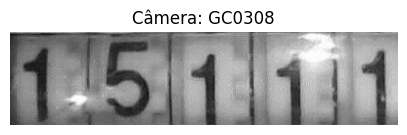

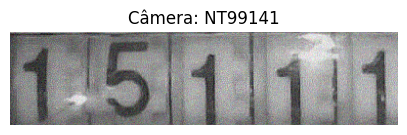

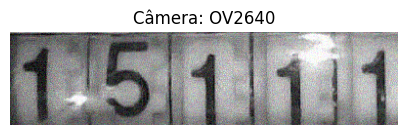

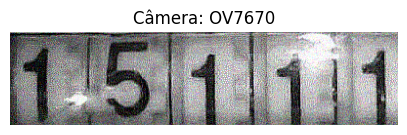

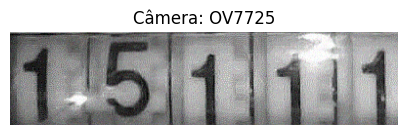

In [ ]:
# AQUI IREMOS PERCORRER CADA TIPO DE CÂMERA COM A MESMA IMAGEM. COM OS PARÂMETROS E ESSA BIBLIOTECA:
for nome, params in cameras.items():
    img_modificada = aplicar_configuracoes_pillow(img, **params)
    plt.figure(figsize=(5,5))
    plt.imshow(img_modificada)
    plt.axis('off')
    plt.title(f"Câmera: {nome}")
    plt.show()


UTILIZANDO A BIBLIOTECA Scikit-Image


In [ ]:
from skimage import io, util, exposure, filters, img_as_float, img_as_ubyte

In [ ]:
def aplicar_configuracoes_skimage(imagem, noise, sharpness, contrast):
    # TRANSFORMA EM FLOAT A IMAGEM
    img = np.array(imagem.convert("RGB"))
    img = img_as_float(img)

    # --- Ajustar contraste ---
    # SE FOR MAIOR QUE 1 A IMAGEM FICA MAIS CLARA
    # SE FOR MENOR DO QUE 1 A IMAGEM FICA MAIS ESCURA
    img = exposure.adjust_gamma(img, gamma=80/contrast)

    # --- Ajustar nitidez (usando unsharp mask) ---
    img = filters.unsharp_mask(img, radius=1.0, amount=sharpness / 100)

    # --- Adicionar ruído gaussiano ---
    img_noisy = util.random_noise(img, mode='gaussian', var=(noise / 100)**2)

    # Converter de volta para imagem Pillow DEPOIS QUE JA FEZ TODOS OS CALCULOS COM O NUMPY E AGR QUER RETORNAR A IMAGEM EM SI MSM
    img_final = Image.fromarray(img_as_ubyte(img_noisy))
    return img_final


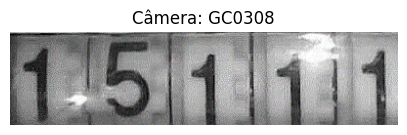

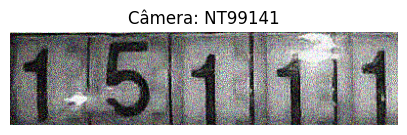

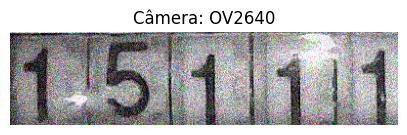

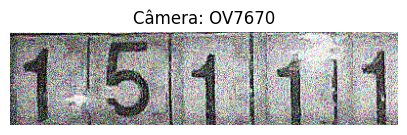

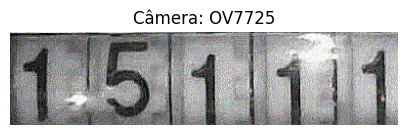

In [ ]:
# Abrir imagem
img = Image.open("/content/10011.png")

# PERCORRE CADA TIPO DE CÂMERA E RETORNA COM A IMAGEM ORIGINAL COM AS ALTERAÇÕES
for nome, params in cameras.items():
    img_modificada = aplicar_configuracoes_skimage(img, **params)
    plt.figure(figsize=(5,5))
    plt.imshow(img_modificada)
    plt.axis('off')
    plt.title(f"Câmera: {nome}")
    plt.show()


UTILIZANDO A BIBLIOTECA SIMPLE TK


In [ ]:
pip install SimpleITK

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.6/52.6 MB 18.4 MB/s eta 0:00:00


In [ ]:
import SimpleITK as sitk

In [ ]:
def aplicar_configuracoes_simpleitk(imagem, noise, sharpness, contrast):
    # PRIMEIRO ELE CONVERTE A IMAGEM EM UM ARRAY NUMPY.
    np_img = np.array(imagem.convert("RGB"), dtype=np.float32)

    # DEPOIS CONVERTE O NUMPY EM UM SITK
    sitk_img = sitk.GetImageFromArray(np_img)

    # Calcular valores mínimos e máximos como floats simples
    min_val = float(np.min(np_img))
    max_val = float(np.max(np_img))

# AQUI IRÁ UTILIZAR O OBJETO sitk QUE CRIAMOS, PARA APLICAR OS FILTROS:

    # --- Ajustar contraste (via windowing) ---
    contrast_factor = contrast / 80.0
    sitk_img = sitk.IntensityWindowing(
        sitk_img,
        windowMinimum=min_val,
        windowMaximum=max_val,
        outputMinimum=0.0,
        outputMaximum=255.0 * contrast_factor
    )

    # --- Ajustar nitidez ---
    sharp_img = sitk.LaplacianSharpening(sitk_img)

    # --- Adicionar ruído gaussiano ---
    noisy_img = sitk.AdditiveGaussianNoise(sharp_img, standardDeviation=float(noise))

    # Converter SimpleITK → NumPy → Pillow
    final_np = sitk.GetArrayFromImage(noisy_img)
    # CONVERTE O OBJETO sitk EM UM NUMPY NOVAMENTE
    final_np = np.clip(final_np, 0, 255).astype(np.uint8)
    # CONVERTE OS VALORES NUMPY EM UMA IMAGEM NOVAMENTE (PILLOW)
    final_img = Image.fromarray(final_np)

    return final_img

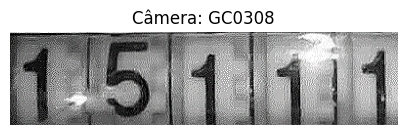

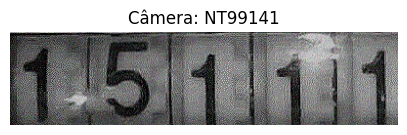

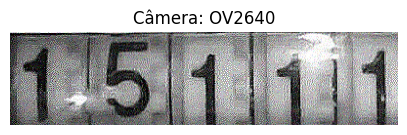

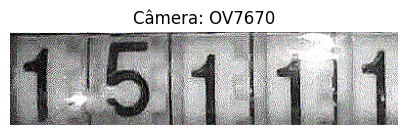

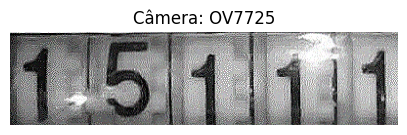

In [ ]:
# Abrir imagem
img = Image.open("/content/10011.png")

# PERCORRE CADA TIPO DE CÂMERA E RETORNA COM A IMAGEM ORIGINAL COM AS ALTERAÇÕES
for nome, params in cameras.items():
    img_modificada = aplicar_configuracoes_simpleitk(img, **params)
    plt.figure(figsize=(5,5))
    plt.imshow(img_modificada)
    plt.axis('off')
    plt.title(f"Câmera: {nome}")
    plt.show()


A PRINCIPAL DIFERENÇA ENTRE A BIBLIOTECA PILLOW PARA A SCKIT-IMAGE, É QUE A PILLOW TRABALHA COM O NUMPY EM UMA ESCALA DE 0 A 255 DA IMAGEM, JÁ O SCKIT-IMAGE COM UMA ESCALA DE 0 A 1.
(lembrando que no PILLOW O 0 É TOTALMENTE PRETO E 255 BRANCO, E NO SCKIT-IMAGE O 0 É TOTALMENTE PRETO E O 1 É TOTALMENTE BRANCO)

E O SCKIT-IMAGE É MAIS 'APROPRIADO' PARA VISÃO COMPUTACIONAL JÁ QUE CONSEGUE UTILIZAR DIVERSOS FORMATOS DE IMAGENS. ENQUANTO, O PILLOW SO CONSEGUE TRABALHAR COM JPEG E PNG.

JÁ O SimpleITK ELE BASICAMENTE UMA BIBLIOTECA DE PROCESSAMENTO DE IMAGENS MÉDICAS, OU SEJA, É MUITO MAIS ROBUSTA, PORÉM, BEM MAIS COMPLEXA PARA APLICAR.
ELA GERALMENTE É UTILIZADA EM IMAGENS DE 2D,3D,4D.